<a href="https://colab.research.google.com/github/Nikhil-Khetani/Car-Image-Generation/blob/main/Car_Image_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets 
from torchvision.utils import save_image
import random
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 64
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
image_size = 64
workers = 1
use_gpu = True

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
#!ls /mydrive
!unzip /mydrive/Car-Image-Generation.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/cars_train/cars_train/03145.jpg  
  inflating: data/cars_train/cars_train/03146.jpg  
  inflating: data/cars_train/cars_train/03147.jpg  
  inflating: data/cars_train/cars_train/03148.jpg  
  inflating: data/cars_train/cars_train/03149.jpg  
  inflating: data/cars_train/cars_train/03150.jpg  
  inflating: data/cars_train/cars_train/03151.jpg  
  inflating: data/cars_train/cars_train/03152.jpg  
  inflating: data/cars_train/cars_train/03153.jpg  
  inflating: data/cars_train/cars_train/03154.jpg  
  inflating: data/cars_train/cars_train/03155.jpg  
  inflating: data/cars_train/cars_train/03156.jpg  
  inflating: data/cars_train/cars_train/03157.jpg  
  inflating: data/cars_train/cars_train/03158.jpg  
  inflating: data/cars_train/cars_train/03159.jpg  
  inflating: data/cars_train/cars_train/03160.jpg  
  inflating: data/cars_train/cars_train/03161.jpg  
  inflating: data/cars_train/cars_train/03162.jpg  
  inflating: 

In [16]:
train_dataroot = "/content/data/cars_train/"
test_dataroot = "/content/data/cars_test/"

In [17]:
train_dataset = datasets.ImageFolder(root=train_dataroot,
                              transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

test_dataset = datasets.ImageFolder(root=test_dataroot,
                              transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


In [39]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3*c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=3*c, out_channels=3*c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*3*8*8*8, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*3*8*8*8, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*3*8*8*8)
        self.conv2 = nn.ConvTranspose2d(in_channels=3*c*2, out_channels=3*c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=3*c, out_channels=3, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 3*capacity*2, 16, 16) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, image_size*image_size), x.view(-1, image_size*image_size), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 21351299


In [40]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: -19019123.306641
Epoch [2 / 100] average reconstruction error: -30323923.750000
Epoch [3 / 100] average reconstruction error: -34189093.375000
Epoch [4 / 100] average reconstruction error: -35932534.906250
Epoch [5 / 100] average reconstruction error: -36814669.843750
Epoch [6 / 100] average reconstruction error: -37660463.781250
Epoch [7 / 100] average reconstruction error: -38321732.312500
Epoch [8 / 100] average reconstruction error: -38678284.875000
Epoch [9 / 100] average reconstruction error: -39052733.343750
Epoch [10 / 100] average reconstruction error: -39549599.781250
Epoch [11 / 100] average reconstruction error: -39903154.343750
Epoch [12 / 100] average reconstruction error: -40174453.093750
Epoch [13 / 100] average reconstruction error: -40347140.562500
Epoch [14 / 100] average reconstruction error: -40528626.187500
Epoch [15 / 100] average reconstruction error: -40721085.937500
Epoch [16 / 100] average reconstruct

KeyboardInterrupt: ignored

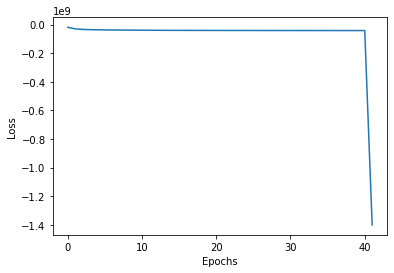

In [41]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [34]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

KeyboardInterrupt: ignored

Original images


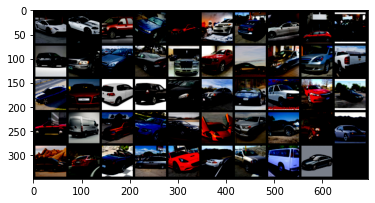

VAE reconstruction:


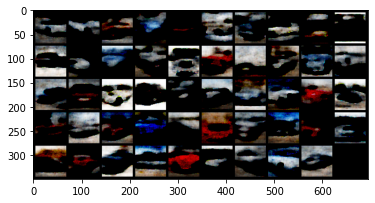

In [42]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

IndexError: ignored

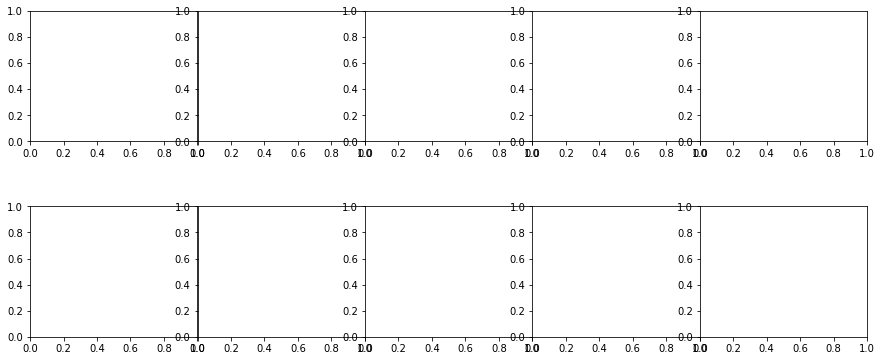

In [43]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

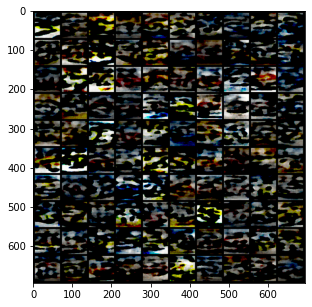

In [44]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

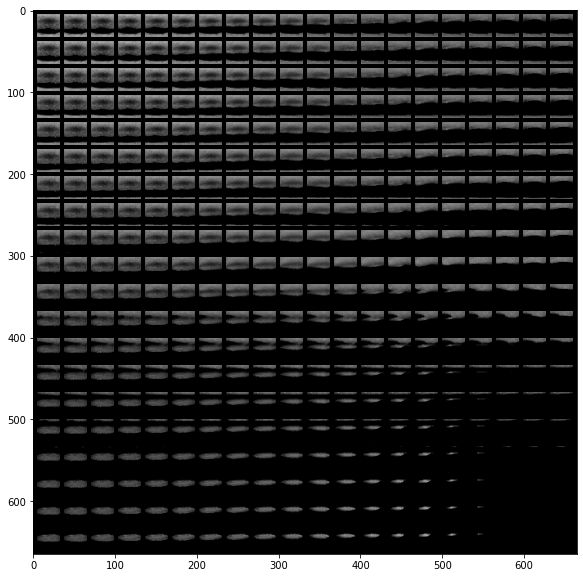

In [19]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()